# Visualize the anchor-target assignment

In [1]:
import os
import random
from pathlib import Path
import numpy as np
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

device = torch.device('cpu')

In [2]:
# Deterministic REPRODUCIBILITY
torch.manual_seed(24)
random.seed(5)
np.random.seed(95)

In [3]:
import io
import contextlib
import cv2
from torchvision.ops import box_convert

In [4]:
from yolort.data import COCODetectionDataModule
from yolort.models.transform import YOLOTransform
from yolort.utils.image_utils import (
    color_list,
    plot_one_box,
    cv2_imshow,
    load_names,
    parse_single_image,
    parse_images,
)

## Setup the coco128 dataset and dataloader for testing

In [5]:
# Get COCO label names and COLORS list
LABELS = (
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush',
)

COLORS = color_list()

In [6]:
# Acquire the images and labels from the coco128 dataset
data_path = Path('data-bin')
coco128_dirname = 'coco128'
coco128_path = data_path / coco128_dirname
image_root = coco128_path / 'images' / 'train2017'
annotation_path = coco128_path / 'annotations'

batch_size = 8

with contextlib.redirect_stdout(io.StringIO()):
    datamodule = COCODetectionDataModule(
        image_root,
        anno_path=annotation_path,
        skip_val_set=True,
        batch_size=batch_size,
    )

In [7]:
test_dataloader = iter(datamodule.train_dataloader())

## Sample images and targets

In [8]:
images, annotations = next(test_dataloader)

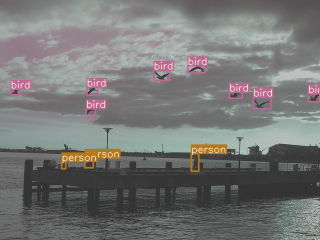

In [9]:
idx = random.randrange(batch_size)
img_raw = cv2.cvtColor(parse_single_image(images[idx]), cv2.COLOR_RGB2BGR)  # For visualization

for box, label in zip(annotations[idx]['boxes'].tolist(), annotations[idx]['labels'].tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)

## Training Batch in Pipeline

In [10]:
from yolort.models import yolov5s

model = yolov5s()
model = model.train()

In [11]:
samples, targets = model.transform(images, annotations)

In [12]:
inputs = parse_images(samples.tensors)

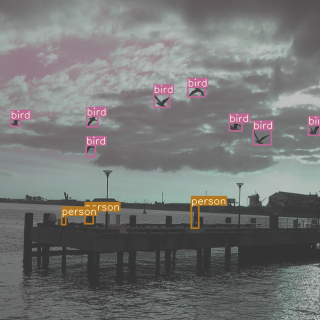

In [13]:
attach_idx = torch.where(targets[:, 0].to(dtype=torch.int32) == idx)[0]

img_training = cv2.cvtColor(inputs[idx], cv2.COLOR_RGB2BGR)  # For visualization
img_h, img_w = img_training.shape[:2]
targets_training = targets[attach_idx]
for box, label in zip(targets_training[:, 2:], targets[attach_idx][:, 1]):
    label = int(label.tolist())
    box = box_convert(box, in_fmt='cxcywh', out_fmt='xyxy')
    box = (box * torch.tensor([img_h, img_w, img_h, img_w])).tolist()
    img_training = plot_one_box(box, img_training, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_training, imshow_scale=0.5)

### Extractor Intermediate Feature

In [14]:
from yolort.utils import FeatureExtractor

In [15]:
yolo_features = FeatureExtractor(model.model, return_layers=['backbone', 'head'])

intermediate_features = yolo_features(samples.tensors, targets)

features = intermediate_features['backbone']
head_outputs = intermediate_features['head']

### Obtain Anchors and Strides

In [16]:
num_layers = len(head_outputs)

anchors = torch.as_tensor(model.model.anchor_generator.anchor_grids, dtype=torch.float32, device=device)
strides = torch.as_tensor(model.model.anchor_generator.strides, dtype=torch.float32, device=device)
anchors = anchors.view(num_layers, -1, 2) / strides.view(-1, 1, 1)

### Assign Targets to Anchors

In [17]:
# Build targets for compute_loss(), input targets(image,class,x,y,w,h)
num_anchors = len(model.model.anchor_generator.anchor_grids)  # number of anchors
num_targets = len(targets)  # number of targets

targets_cls, targets_box, anchors_encode = [], [], []
indices = []
grid_assigner = []  # Anchor Visulization
gain = torch.ones(7, device=device)  # normalized to gridspace gain
# same as .repeat_interleave(num_targets)
ai = torch.arange(num_anchors, device=device).float().view(num_anchors, 1).repeat(1, num_targets)
targets_append = torch.cat((targets.repeat(num_anchors, 1, 1), ai[:, :, None]), 2)  # append anchor indices

g = 0.5  # bias
off = torch.tensor([[0, 0],
                    [1, 0], [0, 1], [-1, 0], [0, -1],  # j,k,l,m
                    # [1, 1], [1, -1], [-1, 1], [-1, -1],  # jk,jm,lk,lm
                    ], device=device).float() * g  # offsets

In [18]:
anchor_threshold = 4.0

What's actually going on is the image is subdivided into a grid of squares, and the coordinates in `grid[]` are the coordinates of the upper-left corner of that square.

The neural network provides $x$, $y$ coordinates in the range $(0, 1)$ (enforced by sigmoid) which covers the square, centered at 0.5. Multiplying by two allows detected $x$, $y$ coordinates to cover a larger range, slightly outside the square -- otherwise it's difficult to detect objects centered at grid boundaries. Subtracting 0.5 shifts the resulting range to $(-0.5, 1.5)$ which is centered around $(0, 1)$.

In [19]:
for i in range(num_layers):
    anchors_per_layer = anchors[i]
    gain[2:6] = torch.tensor(head_outputs[i].shape)[[3, 2, 3, 2]]  # xyxy gain

    # Match targets to anchors
    targets_with_gain = targets_append * gain
    if num_targets:
        # Matches
        ratios_wh = targets_with_gain[:, :, 4:6] / anchors_per_layer[:, None]  # wh ratio
        ratios_filtering = torch.max(ratios_wh, 1. / ratios_wh).max(2)[0]
        inds = torch.where(ratios_filtering < anchor_threshold)
        targets_with_gain = targets_with_gain[inds]  # filter

        # Offsets
        grid_xy = targets_with_gain[:, 2:4]  # grid xy
        grid_xy_inverse = gain[[2, 3]] - grid_xy  # inverse
        inds_jk = (grid_xy % 1. < g) & (grid_xy > 1.)
        inds_lm = (grid_xy_inverse % 1. < g) & (grid_xy_inverse > 1.)
        inds_ones = torch.ones_like(inds_jk[:, 0])[:, None]
        inds = torch.cat((inds_ones, inds_jk, inds_lm), dim=1).T
        targets_with_gain = targets_with_gain.repeat((5, 1, 1))[inds]
        offsets = (torch.zeros_like(grid_xy)[None] + off[:, None])[inds]
    else:
        targets_with_gain = targets_append[0]
        offsets = torch.tensor(0, device=device)

    # Define
    bc = targets_with_gain[:, :2].long().T  # image, class
    grid_xy = targets_with_gain[:, 2:4]  # grid xy
    grid_wh = targets_with_gain[:, 4:6]  # grid wh
    grid_ij = (grid_xy - offsets).long()

    # Append
    a = targets_with_gain[:, 6].long()  # anchor indices
    # image, anchor, grid indices
    indices.append((bc[0], a, grid_ij[:, 1].clamp_(0, gain[3] - 1),
                    grid_ij[:, 0].clamp_(0, gain[2] - 1)))
    targets_box.append(torch.cat((grid_xy - grid_ij, grid_wh), 1))  # box
    grid_assigner.append(torch.cat((grid_xy, grid_wh), 1))
    anchors_encode.append(anchors_per_layer[a])  # anchors
    targets_cls.append(bc[1])  # class

### Visulization Anchor

In [20]:
from yolort.utils.image_utils import anchor_match_visualize

In [21]:
images_with_anchor = anchor_match_visualize(samples.tensors, grid_assigner, indices, anchors_encode, head_outputs)

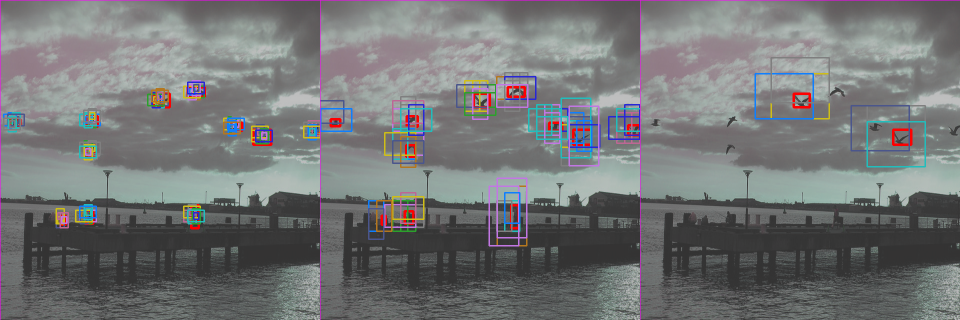

In [22]:
cv2_imshow(images_with_anchor[idx], imshow_scale=0.5)